This tutorials reproduces section III.A from:

- L. Tsunaki, A. Singh, S. Trofimov, & B. Naydenov. (2025). Digital Twin Simulations Toolbox of the Nitrogen-Vacancy Center in Diamond. arXiv:2507.18759 quant-ph. [2507.18759](https://arxiv.org/abs/2507.18759).

Conditional gates form the building block for quantum information processing applications involving more than one qubit. In case of the NV center, the energy level structure permits to realize them straightforwardly through selective MW and RF pulses.
To begin illustrating the use of the NV software component, we introduce a simple application of a two-qubit conditional gate between the electron spin of the NV and a nuclear spin from a strongly coupled 13C from the diamond lattice, first observed in:

- F. Jelezko, T. Gaebel, I. Popa, M. Domhan, A. Gruber,and J. Wrachtrup, Observation of coherent oscillation of a single nuclear spin and realization of a two-qubit conditional quantum gate, Phys. Rev. Lett. 93, 130501 (2004).

In [1]:
import numpy as np
from qutip import jmat, tensor, qeye, basis

from quaccatoo import NV, Rabi, square_pulse, Analysis

# 1. System Definition

First, the NV system is represented by an instance of the `NV` class for a given external magnetic field $\mathbf{B}_0$.
This can be obtained simply through the following code:

In [5]:
sys = NV(B0=200, units_B0='mT', N=0)

where the parameter `N` representing the nitrogen isotope is set to 0.
This way, we neglect the nitrogen nuclear spin, which is not used in this application.
The external magnetic field is assumed to be aligned with the NV axis and to have a magnitude of $B_0 = 200$ mT.
The `NV` class internally calculates the system's observable $\hat{F}_S$ and Hamiltonian $\hat{H}_0$, in units of MHz by default. This way, the time units are in microseconds.

So far, only the electron spin of the NV is defined.
To add the 13C spin to the system, the $\hat{H}_2$ Hamiltonian needs to be defined.
In this case, the internal Hamiltonian of the 13C spin is simply given by a Zeeman interaction along the $z$-axis, while the hyperfine coupling between the two spins can be expressed in terms of a single component of $a_{zz}^c=130$ MHz, even though other spatial components might exist.
Hence,
$$
	\hat{H}_2 = a_{zz}^c \hat{S}_z \hat{I}^c_z - \gamma^c B_0 \hat{I}^c_z
$$
with gyromagnetic ratio $\gamma^c= 10.7084$ MHz/T.
To model this interaction and to add the carbon spin to the NV, the `add_spin` method can be used as follows:

In [6]:
GAMMA_C = 10.7084e-3
azz = 130

H2 = azz*tensor(jmat(1,'z'),jmat(1/2,'z')) - GAMMA_C*sys.B0*tensor(qeye(3),jmat(1/2,'z'))

sys.add_spin(H2)

sys.rho0 = tensor(basis(3,1),basis(2,1))

with `tensor` representing the tensor product, `jmat` giving the spin matrices, `basis` the $Z$ basis states, and `qeye` the identity matrices, all imported from QuTiP.
The initial state of the nuclear spin in this application is polarized, where $\ket{m_S=0}\otimes\ket{m_{I^c}=-1/2}$ is set to the `rho0` attribute as shown above.
Therefore, the states are pure and can be represented as kets, instead of density matrices.
Which makes the simulation computationally less costly, given that there are fewer ODEs to be solved in the ket state as compared to the whole density matrix.

The energy levels of the system can be plotted with the `plot_energy` method:

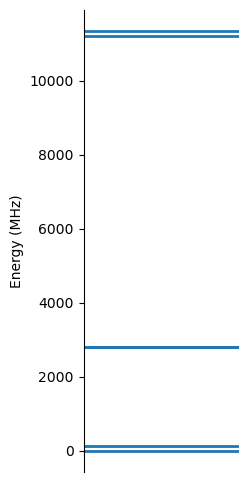

In [7]:
sys.plot_energy()

At such magnetic field above GSLAC $B_0 > B_{\textrm{GSLAC}}$, the $m_S=0$ state has a higher energy than $m_S=-1$.
Furthermore, the nuclear states at $m_S=0$ are only split by its Zeeman interaction, while the sublevels at $m_S=-1$ have a contribution from the hyperfine coupling as well.
In this application, it is important that the $\ket{m_S=0} \leftrightarrow \ket{m_S=-1}$ transitions have very distinct frequencies at $m_{I^c}=+1/2$ and $m_{I^c}=-1/2$ nuclear states, in order to avoid unwanted excitations.
This is ensured by the high intensity magnetic field $B_0$ and hyperfine coupling $a^c_{zz}$, which leads to these energy differences being much larger than the bandwidth of the pulses.

The interaction with an external excitation field needs to be represented through the operator $\hat{h}_1$.
Assuming $\mathbf{B}_1(t)$ along the $x$-axis and Rabi frequencies of
$\omega_{1,S} = 20$ MHz and $\omega_{1,I} = 0.8$ MHz for the electron and nuclear spins, respectively, we have:

In [8]:
w1_S = 20
w1_I = 0.8	

h1 = w1_S*tensor(jmat(1,'x')*2**.5,qeye(2)) + w1_I*tensor(qeye(3),jmat(1/2,'x')*2)

w0_mw = sys.energy_levels[2]-sys.energy_levels[1]
w0_rf = sys.energy_levels[1]

where we also define the frequencies of the pulses `w0_mw` and `w0_rf` in resonance with the transitions. By default, in QuaCCAToo, the lowest energy state in system is 0, `sys.energy_levels[0]=0`.

# 2. Electron Spin Rabi

Finally, for simulating this interaction of the excitation with the electron spin, we use the `Rabi` class and the `square_pulse` function to model the $\mathbf{B}_1(t)$ field.
Typically, in a Rabi experiment, the MW (or RF) pulse length is varied, which causes a periodic oscillation of the observable with frequency $\omega_1$.
Given the necessary parameters defined previously and an array for the pulse durations, this is achieved by:

In [9]:
tp_S = np.linspace(0,0.15,1000)

rabi_S_sim = Rabi(
	system = sys,
	pulse_duration = tp_S,
	h1 = h1,
	pulse_params = {'f_pulse':w0_mw},
	pulse_shape = square_pulse
	)

rabi_S_sim.run()

The `run` method is used to execute the simulation, by setting and solving the coupled ODEs, where the results of the simulations are stored in the `results` attribute of the `rabi_S_sim` object. 
Here, the frequency of the excitation field $\mathbf{B}_1(t)$ is passed to the object through the `f_pulse` key of the `pulse_params` dictionary variable.

The resulting expectation value of the fluorescence observable as a function of the pulse length can be plotted with the `plot_results` method from the `Analysis` class.
The electron spin performs full Rabi oscillations between the $m_S=0$ and $m_S=-1$ levels, conditioned to the 13C spin being at the $m_{I^c}=-1/2$ state.
The $m_S=+1$ levels and the nuclear states are not affected by this pulse, as expected.

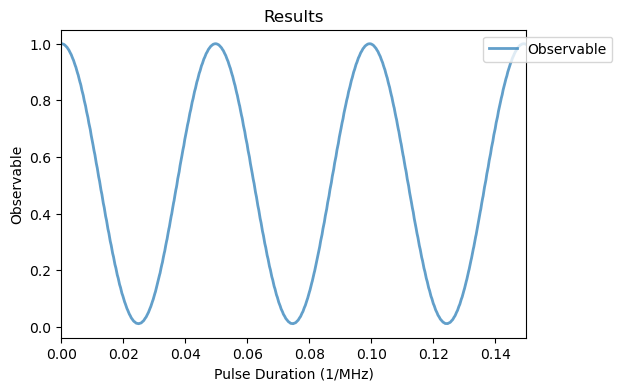

In [11]:
Analysis(rabi_S_sim).plot_results()

# 3. Nuclear Spin Rabi

Apart from a conditional rotation of the electron spin, the carbon nuclear spin can also be excited by setting `f_pulse` in resonance with `w0_rf`.
Now, we consider $\ket{m_S=-1}\otimes\ket{m_{I^c}=+1/2}$ as the initial state and define an observable for the nuclear spin as
$$
 \hat{F}_{I^c} = \hat{1} \otimes \ket{+1/2}\bra{+1/2} .
$$
Experimentally, this is indirectly measured through the electron by electron-nuclear double magnetic resonance (ENDOR).
To model the decoherence of the spin, we assume $\hat{C}=\hat{I}^c_z$ as the collapse operator, with rate $\Gamma_2 = 0.5$ MHz.
Altogether, the time-evolution of the nuclear spin within these considerations is simulated by:

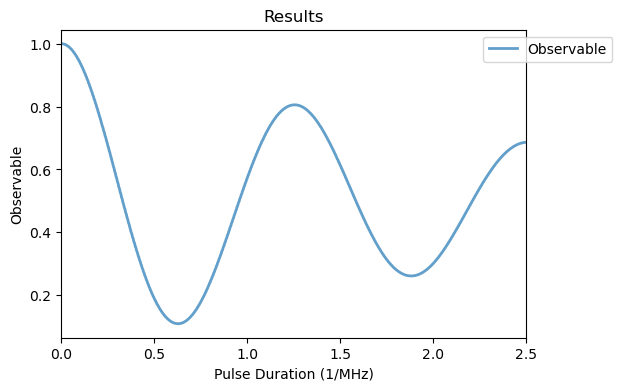

In [12]:
sys.rho0 = tensor(basis(3,2),basis(2,0))
sys.observable = tensor(qeye(3),basis(2,0)*basis(2,0).dag())

gamma2 = .5
sys.c_ops = gamma2*tensor(qeye(3),jmat(1/2,'z'))

tp_I = np.linspace(0,2.5,1000)

rabi_I_sim = Rabi(
	system = sys,
	pulse_duration = tp_I,
	h1 = h1,
	pulse_params = {'f_pulse':w0_rf}
	)

rabi_I_sim.run()
Analysis(rabi_I_sim).plot_results()

where the `c_ops` attribute of the `NV` instance, which was previously empty, is now set to the operator.
The `pulse_shape` parameter is set to square pulses by default, which will be omitted from now on.

Differently from the electron spin, the oscillation is damped by decoherence of the nuclear spin and has a much smaller Rabi frequency due to the smaller gyromagnetic ratio and thus, weaker coupling to the excitation field $\mathbf{B}_1(t)$.
The software component accurately reproduces the results presented in the reference, apart from the fact that the simulations present a much larger contrast.
This can be attributed to an imperfect initialization of the spins in the experiments, which are not accounted in the simulations.
Together with unconditional excitations, these two rotations form the computational basis for arbitrary quantum gates with the NV-$^{13}$C pair, which will be further explored in the subsequent tutorials.